### Earthquake Modeling

In [74]:
%matplotlib inline
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import shap
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, average_precision_score

import scikitplot as skplt

warnings.filterwarnings("ignore")


#### 1. Load the cleaned data

In [3]:
earthquakes = pd.read_csv('master_df.csv')
print(earthquakes.shape)

earthquakes_reduced = pd.read_csv('master_df_reduced.csv')
print(earthquakes_reduced.shape)

earthquakes_reg_pop = pd.read_csv('master_df_regional_pop.csv')
print(earthquakes_reg_pop.shape)


(1030, 44)
(1030, 11)
(1030, 49)


#### 2. Explore Dataset and Missing Values

In [4]:
earthquakes_reduced.head()

,Unnamed: 0,Year,Country,Latitude,Longitude,Focal Depth (km),Mag,Average Income,p0p50_share,pop_total,badness_value
0,0,2000,CHINA,40.498,122.994,10.0,5.1,4836.4401,0.1737,20899032.0,0.521739
1,1,2000,CHINA,25.607,101.063,33.0,5.9,4836.4401,0.1737,38290493.0,0.565217
2,2,2000,CHINA,26.856,97.238,33.0,6.3,4836.4401,0.1737,47881124.0,0.130435
3,3,2000,CHINA,25.826,102.194,33.0,4.2,4836.4401,0.1737,1307028.0,0.347826
4,4,2000,IRAN,35.288,58.218,33.0,5.3,13549.8134,0.1232,5372795.0,0.391304


In [5]:
earthquakes_reg_pop.head()

,Unnamed: 0,Year,Mo,Dy,Hr,Mn,Sec,Tsu,Vol,Country,...,Total Houses Damaged Description,Total Houses Damaged Description.1,Region,Average Income,p0p50_share,Population density national,preperation_zone,pop_with_water,pop_without_water,pop_total
0,0,2000,1,11,23.0,43.0,56.4,NaN,NaN,CHINA,...,4.0,4.0,LIAONING PROVINCE,4836.4401,0.1737,134.647500,164.9,196.047281,248.925429,2.089903e+07
1,1,2000,1,14,23.0,37.0,7.8,NaN,NaN,CHINA,...,NaN,NaN,YAOAN COUNTY,4836.4401,0.1737,134.647500,356.1,75.744613,76.155580,3.829049e+07
2,2,2000,6,7,21.0,46.0,55.9,NaN,NaN,CHINA,...,NaN,NaN,LIUKU; MYANMAR,4836.4401,0.1737,134.647500,572.6,36.681915,38.318019,4.788112e+07
3,3,2000,8,21,13.0,25.0,44.5,NaN,NaN,CHINA,...,NaN,NaN,WUDING,4836.4401,0.1737,134.647500,70.2,67.648044,67.648044,1.307028e+06
4,4,2000,2,2,22.0,58.0,1.5,NaN,NaN,IRAN,...,3.0,3.0,KASHMAR,13549.8134,0.1232,40.397152,212.7,30.027525,30.027525,5.372795e+06


In [6]:
earthquakes_reduced.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1030 entries, 0 to 1029
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        1030 non-null   int64  
 1   Year              1030 non-null   int64  
 2   Country           1030 non-null   object 
 3   Latitude          1030 non-null   float64
 4   Longitude         1030 non-null   float64
 5   Focal Depth (km)  1030 non-null   float64
 6   Mag               1030 non-null   float64
 7   Average Income    1030 non-null   float64
 8   p0p50_share       1030 non-null   float64
 9   pop_total         1030 non-null   float64
 10  badness_value     1030 non-null   float64
dtypes: float64(8), int64(2), object(1)
memory usage: 88.6+ KB


Counting Missing values on the dataset

In [7]:
df = earthquakes_reduced.copy()
# number and percentage of missing values according to columns
{col: [df[col].isnull().sum(), f'% {np.round(np.mean(df[col].isnull()*100), 3)}'
      ] for col in df.columns if df[col].isnull().any()}

{}

#### 3. Categorical badness value

In [30]:
def categorize_badness(row):
    if row < 0.1:
        return 1
    elif row < 0.2:
        return 2
    elif row < 0.3:
        return 3
    elif row < 0.4:
        return 4
    elif row < 0.6:
        return 5
    elif row < 0.8:
        return 6
    else:
        return 7

In [31]:
df["Badness_Category"]  = df["badness_value"]
df["Badness_Category"] = df["Badness_Category"].apply(lambda row: categorize_badness(row))

In [32]:
print("Type 1:", (df["Badness_Category"]==1).sum())
print("Type 2:",(df["Badness_Category"]==2).sum())
print("Type 3:",(df["Badness_Category"]==3).sum())
print("Type 4:",(df["Badness_Category"]==4).sum())
print("Type 5:",(df["Badness_Category"]==5).sum())
print("Type 6:",(df["Badness_Category"]==6).sum())
print("Type 7:",(df["Badness_Category"]==7).sum())
print("Type 8:",(df["Badness_Category"]==8).sum())
print("Type 9:",(df["Badness_Category"]==9).sum())
print("Type 10:",(df["Badness_Category"]==10).sum())

Type 1: 304
Type 2: 210
Type 3: 170
Type 4: 164
Type 5: 102
Type 6: 61
Type 7: 19
Type 8: 0
Type 9: 0
Type 10: 0


#### 4.Modeling

a) HistGradientBoostingRegressor (LightGBM Boosted trees)

b) CatBoost boosted trees

c) Random Forest

d) Extremely Randomized Trees

e) k- Nearest Neighbours

3.1 Split numerical and categorical variables

We define "Badness value categorical" as the Target Variable that ranges between 1 to 4 and that is associate to the degree of damage of each Earthquake. As it normally can be treated as a Target Categorical variable, we prefer to use it as a discrete continuos variable due to the fact that there is a lot of missing values in the datasets. 

In [33]:
num_df = df.select_dtypes(include='number')
cat_df = df.select_dtypes(exclude='number')

3.2. Impute Numerical values with KNN Imputer method

In [63]:

# Create an instance of KNNImputer
#imputer = KNNImputer(n_neighbors=5)

#assuming that Total Damage Description is the target variable with meaning of the values between 0 and 4

X = num_df.drop('Badness_Category', axis=1)
y = num_df['Badness_Category']

# Use KNNImputer to fill NaN values in 'y'
#y = imputer.fit_transform(y.values.reshape(-1,1))

# Now 'y' is a 2D array, reshape it to 1D
#y = y.reshape(-1)

# Split the data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)


3.3 Train and Test Ensambles and Tree-based Regressor Models

a) HistGradientBoostingRegressor (LightGBM Boosted trees)

In [67]:
# Train the model
est = GradientBoostingClassifier().fit(x_train, y_train)

predictions = est.predict(x_test)

accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions, average=None)
recall = recall_score(y_test, predictions, average=None)
f1 = f1_score(y_test, predictions, average=None)
#roc_auc = roc_auc_score(y_test, predictions)
#pr_auc = average_precision_score(y_test, predictions)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)
#print("ROC-AUC:", roc_auc)
#print("PR-AUC:", pr_auc)

Accuracy: 1.0
Precision: [1. 1. 1. 1. 1. 1. 1.]
Recall: [1. 1. 1. 1. 1. 1. 1.]
F1-score: [1. 1. 1. 1. 1. 1. 1.]


b) CatBoost boosted trees

In [69]:

# Train the model
est_catboost = CatBoostClassifier().fit(x_train, y_train)

predictions_catboost = est_catboost.predict(x_test)

accuracy = accuracy_score(y_test, predictions_catboost)
precision = precision_score(y_test, predictions_catboost, average=None)
recall = recall_score(y_test, predictions_catboost, average=None)
f1 = f1_score(y_test, predictions_catboost, average=None)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Learning rate set to 0.077643
0:	learn: 1.6759316	total: 4.27ms	remaining: 4.26s
1:	learn: 1.4752838	total: 9.35ms	remaining: 4.67s
2:	learn: 1.3446670	total: 14.9ms	remaining: 4.95s
3:	learn: 1.2110879	total: 20.2ms	remaining: 5.02s
4:	learn: 1.0931963	total: 24.6ms	remaining: 4.89s
5:	learn: 1.0162606	total: 31.1ms	remaining: 5.15s
6:	learn: 0.9465164	total: 36.4ms	remaining: 5.16s
7:	learn: 0.8518126	total: 41.5ms	remaining: 5.14s
8:	learn: 0.7685549	total: 46.4ms	remaining: 5.1s
9:	learn: 0.7102235	total: 51.9ms	remaining: 5.14s
10:	learn: 0.6617986	total: 58ms	remaining: 5.21s
11:	learn: 0.6227882	total: 64.4ms	remaining: 5.3s
12:	learn: 0.5697725	total: 69.7ms	remaining: 5.29s
13:	learn: 0.5383031	total: 75.7ms	remaining: 5.33s
14:	learn: 0.4963023	total: 80.1ms	remaining: 5.26s
15:	learn: 0.4665319	total: 85ms	remaining: 5.23s
16:	learn: 0.4320783	total: 89.3ms	remaining: 5.16s
17:	learn: 0.4038718	total: 93.9ms	remaining: 5.12s
18:	learn: 0.3771046	total: 97.8ms	remaining: 5.05

c) Random Forest

In [70]:

# Train the model
est_randomforest = RandomForestClassifier().fit(x_train, y_train)

predictions_randomforest = est_randomforest.predict(x_test)

accuracy = accuracy_score(y_test, predictions_randomforest)
precision = precision_score(y_test, predictions_randomforest, average=None)
recall = recall_score(y_test, predictions_randomforest, average=None)
f1 = f1_score(y_test, predictions_randomforest, average=None)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)



Accuracy: 0.9529411764705882
Precision: [1.         1.         1.         0.88679245 0.92307692 0.73333333
 1.        ]
Recall: [1.         1.         0.98333333 0.97916667 0.82758621 0.91666667
 0.22222222]
F1-score: [1.         1.         0.99159664 0.93069307 0.87272727 0.81481481
 0.36363636]


d) Extremely Randomized Trees

In [71]:
# Create an instance of KNNImputer
#imputer = KNNImputer(n_neighbors=5)

#assuming that Total Damage Description is the target variable with meaning of the values between 0 and 4

#X = num_df.drop('Badness_Category', axis=1)
#y = num_df['Badness_Category']

# Use KNNImputer to fill NaN values in 'y'
#y = imputer.fit_transform(y.values.reshape(-1,1))
#X = imputer.fit_transform(X)

# Now 'y' is a 2D array, reshape it to 1D
#y = y.reshape(-1)

# Split the data
#x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

# Train the model
est_extratrees = ExtraTreesClassifier().fit(x_train, y_train)

predictions_extratrees = est_extratrees.predict(x_test)

accuracy = accuracy_score(y_test, predictions_extratrees)
precision = precision_score(y_test, predictions_extratrees, average=None)
recall = recall_score(y_test, predictions_extratrees, average=None)
f1 = f1_score(y_test, predictions_extratrees, average=None)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.9470588235294117
Precision: [0.95876289 0.97260274 0.96610169 0.92307692 0.89655172 0.90909091
 0.875     ]
Recall: [1.         0.92207792 0.95       1.         0.89655172 0.83333333
 0.77777778]
F1-score: [0.97894737 0.94666667 0.95798319 0.96       0.89655172 0.86956522
 0.82352941]


e) K- Nearest Neigbours

In [72]:
# Train the model
est_knn = KNeighborsClassifier().fit(x_train, y_train)

predictions_knn = est_knn.predict(x_test)

accuracy = accuracy_score(y_test, predictions_knn)
precision = precision_score(y_test, predictions_knn, average=None)
recall = recall_score(y_test, predictions_knn, average=None)
f1 = f1_score(y_test, predictions_knn, average=None)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)



Accuracy: 0.2323529411764706
Precision: [0.26344086 0.16326531 0.28205128 0.16666667 0.15       0.23076923
 0.        ]
Recall: [0.52688172 0.1038961  0.18333333 0.10416667 0.10344828 0.125
 0.        ]
F1-score: [0.35125448 0.12698413 0.22222222 0.12820513 0.12244898 0.16216216
 0.        ]


In [73]:
est_DT = DecisionTreeClassifier().fit(x_train, y_train)

predictions_DT = est_knn.predict(x_test)

accuracy = accuracy_score(y_test, predictions_DT)
precision = precision_score(y_test, predictions_DT, average=None)
recall = recall_score(y_test, predictions_DT, average=None)
f1 = f1_score(y_test, predictions_DT, average=None)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Accuracy: 0.2323529411764706
Precision: [0.26344086 0.16326531 0.28205128 0.16666667 0.15       0.23076923
 0.        ]
Recall: [0.52688172 0.1038961  0.18333333 0.10416667 0.10344828 0.125
 0.        ]
F1-score: [0.35125448 0.12698413 0.22222222 0.12820513 0.12244898 0.16216216
 0.        ]


3.4 Model Comparision

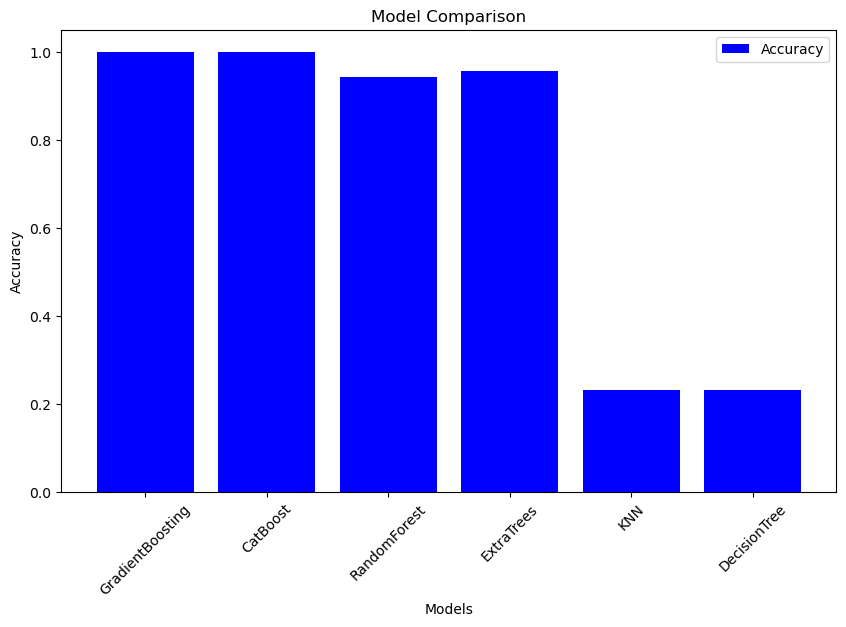

In [52]:
# Define the model names and corresponding scores
model_names = ['GradientBoosting', 'CatBoost', 'RandomForest', 'ExtraTrees', 'KNN', "DecisionTree"]
accuracys = [accuracy_score(y_test, predictions), accuracy_score(y_test, predictions_catboost), accuracy_score(y_test, predictions_extratrees), accuracy_score(y_test, predictions_randomforest), accuracy_score(y_test, predictions_knn),accuracy_score(y_test, predictions_DT)]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(model_names, accuracys, color='blue', label='Accuracy')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Model Comparison')
plt.legend()
plt.xticks(rotation=45)

plt.show()

### Plotting the confusion matrices


<AxesSubplot:title={'center':'Confusion Matrix of GradientBoosting Predictions'}, xlabel='Predicted label', ylabel='True label'>

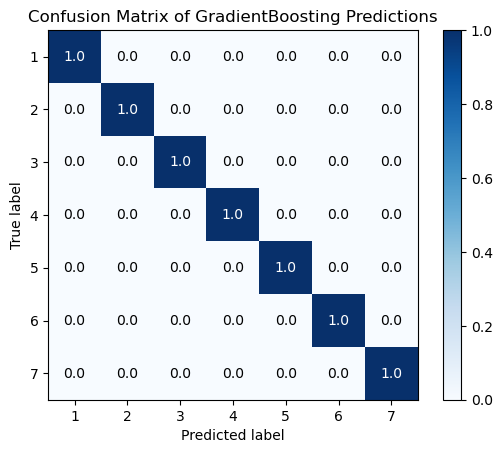

In [46]:
skplt.metrics.plot_confusion_matrix(y_test, predictions, normalize=True, title = 'Confusion Matrix of GradientBoosting Predictions')

<AxesSubplot:title={'center':'Confusion Matrix of CatBoost Predictions'}, xlabel='Predicted label', ylabel='True label'>

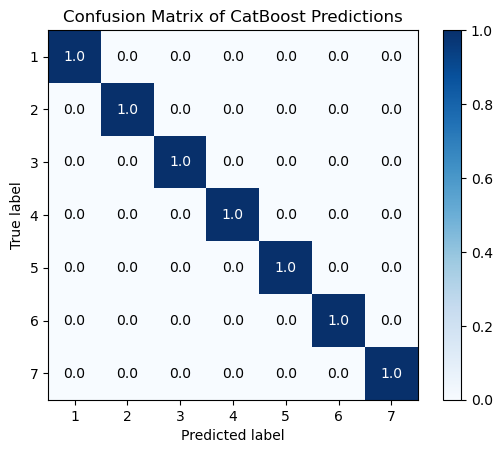

In [47]:
skplt.metrics.plot_confusion_matrix(y_test, predictions_catboost, normalize=True, title = 'Confusion Matrix of CatBoost Predictions')

<AxesSubplot:title={'center':'Confusion Matrix of RandomForest Predictions'}, xlabel='Predicted label', ylabel='True label'>

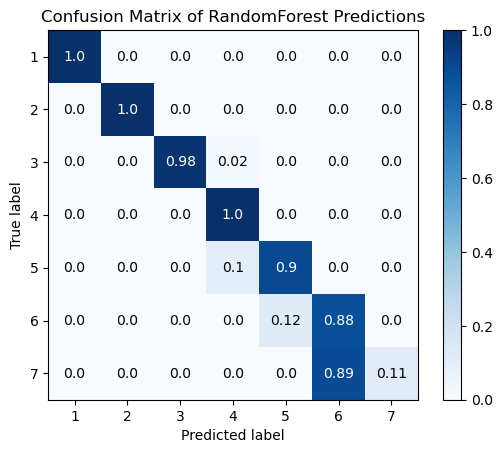

In [43]:
skplt.metrics.plot_confusion_matrix(y_test, predictions_randomforest, normalize=True, title = 'Confusion Matrix of RandomForest Predictions')

<AxesSubplot:title={'center':'Confusion Matrix of ExtraTrees Predictions'}, xlabel='Predicted label', ylabel='True label'>

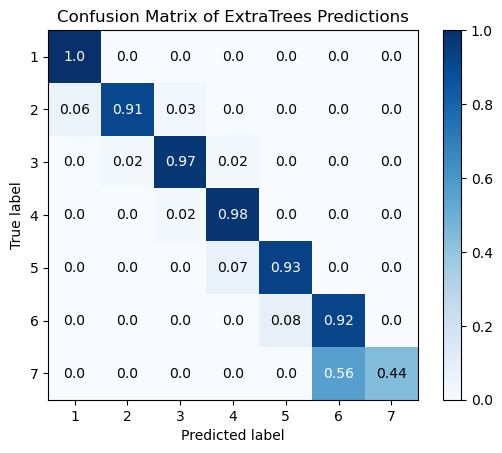

In [44]:
skplt.metrics.plot_confusion_matrix(y_test, predictions_extratrees, normalize=True, title = 'Confusion Matrix of ExtraTrees Predictions')

<AxesSubplot:title={'center':'Confusion Matrix of KNN Predictions'}, xlabel='Predicted label', ylabel='True label'>

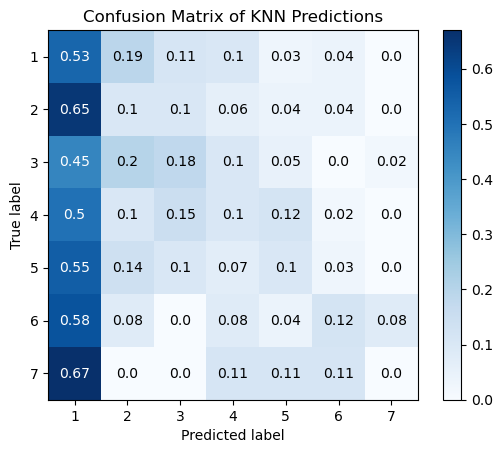

In [45]:
skplt.metrics.plot_confusion_matrix(y_test, predictions_knn, normalize=True, title = 'Confusion Matrix of KNN Predictions')

<AxesSubplot:title={'center':'Confusion Matrix of DT Predictions'}, xlabel='Predicted label', ylabel='True label'>

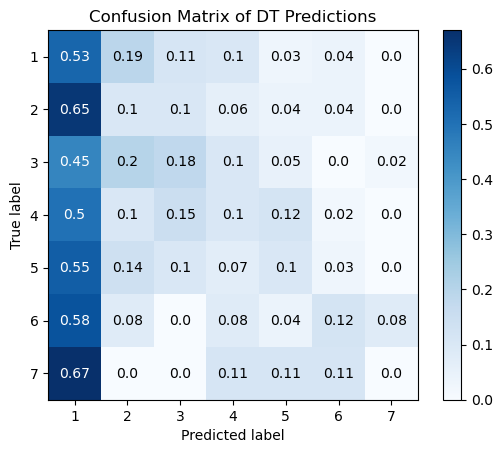

In [53]:
skplt.metrics.plot_confusion_matrix(y_test, predictions_DT, normalize=True, title = 'Confusion Matrix of DT Predictions')